## Method
*Similar to experiment_12_3 but add MSE measure
- Normalize prediction risk maps (0, 1)
- Get maximum prediction (max cell among DB) risk map based on risk matrix obtained from different DB (experiment_10_2_SEPPexp...)
- Measure hit rate, PAI and MSE considering different ground truth scenarios:
    1. SIEDCO
    2. RNMC
    3. NUSE

## Hypothesis: 
MSE between multimodal prediction (using max_by_cell operator) and ground truth maps (by DB) is higher than MSEs obtained on unimodal and multimodal-average scenarios.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def normalize_grid_prediction(row, column_name):
    xoffset = row[column_name]._xoffset
    yoffset = row[column_name]._yoffset
    xsize = row[column_name]._xsize
    ysize = row[column_name]._ysize
    matrix_norm = row[column_name]._matrix.copy()
    # Uses 1 division and matix.size multiplications, multiplication is faster than division
    matrix_norm *= 1/row[column_name]._matrix.max()
    return open_cp.predictors.GridPredictionArray(xsize=xsize,ysize=ysize,matrix=matrix_norm,xoffset=xoffset,yoffset=yoffset)
    

## Fusion operators

In [5]:
def average_grid_prediction(row):
    xoffset_avg = (row['prediction_siedco']._xoffset + row['prediction_rnmc']._xoffset + row['prediction_nuse']._xoffset)/3
    yoffset_avg = (row['prediction_siedco']._yoffset + row['prediction_rnmc']._yoffset + row['prediction_nuse']._yoffset)/3
    xsize_avg = (row['prediction_siedco']._xsize + row['prediction_rnmc']._xsize + row['prediction_nuse']._xsize)/3
    ysize_avg = (row['prediction_siedco']._ysize + row['prediction_rnmc']._ysize + row['prediction_nuse']._ysize)/3
    matrix_avg = (row['prediction_siedco']._matrix + row['prediction_rnmc']._matrix + row['prediction_nuse']._matrix)/3
    return open_cp.predictors.GridPredictionArray(xsize=xsize_avg,ysize=ysize_avg,matrix=matrix_avg,xoffset=xoffset_avg,yoffset=yoffset_avg)

In [6]:
import operator

def maximum_grid_prediction(row):
    max_intensity = {}
    max_intensity['siedco']=np.sum(row['prediction_siedco']._matrix)
    max_intensity['rnmc']=np.sum(row['prediction_rnmc']._matrix)
    max_intensity['nuse']=np.sum(row['prediction_nuse']._matrix)
    key_max_intensity = max(max_intensity.items(), key=operator.itemgetter(1))[0]
    
    column = 'prediction_'+str(key_max_intensity)
    xoffset_max = row[column]._xoffset
    yoffset_max = row[column]._yoffset
    xsize_max = row[column]._xsize
    ysize_max = row[column]._ysize
    matrix_max = row[column]._matrix
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_max,xoffset=xoffset_max,yoffset=yoffset_max)


In [7]:
def maximum_by_cell(row):
    matrix_1 = np.maximum(row['prediction_siedco']._matrix, row['prediction_rnmc']._matrix)
    matrix_2 = np.maximum(matrix_1, row['prediction_nuse']._matrix)
    # assign any from DB, since all attributes are equal
    xoffset_max = row['prediction_siedco']._xoffset
    yoffset_max = row['prediction_siedco']._yoffset
    xsize_max = row['prediction_siedco']._xsize
    ysize_max = row['prediction_siedco']._ysize
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_2,xoffset=xoffset_max,yoffset=yoffset_max)

## Load prediction results

In [8]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [9]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [10]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

## Normalize prediction intensity risk maps

In [11]:
loaded_siedco['prediction_normalized'] = loaded_siedco.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_rnmc['prediction_normalized'] = loaded_rnmc.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_nuse['prediction_normalized'] = loaded_nuse.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)


In [12]:
loaded_siedco = loaded_siedco.rename(columns={'prediction_normalized': 'prediction_siedco', 'eval_pts': 'eval_pts_siedco'})
loaded_rnmc = loaded_rnmc.rename(columns={'prediction_normalized': 'prediction_rnmc', 'eval_pts': 'eval_pts_rnmc'})
loaded_nuse = loaded_nuse.rename(columns={'prediction_normalized': 'prediction_nuse', 'eval_pts': 'eval_pts_nuse'})

## Compute maximum prediction

In [13]:
result = pd.concat([loaded_siedco, loaded_rnmc, loaded_nuse], axis=1)

In [14]:
result['max_prediction'] = result.apply(lambda row: maximum_by_cell(row), axis=1)

## Hit rate, PAI and MSE

#### Real percentage of city coverage over rectangular region (based on script experiment_11_1_get_rectangular_city_region):

In [15]:
city_percentage_on_region = 0.26

In [16]:
## coverages are represented in % (NOT IN PROPORTION)
coverages = [2,4,6,8,10,12,14,16,18,20]
### this approach is only used to open_cp hit rate implementation method makes sense
real_coverages_city = list(map(lambda c: round((c/100)*city_percentage_on_region*100, 1), coverages))

In [17]:
## coverages are represented in % (NOT IN PROPORTION)
real_coverages_city

[0.5, 1.0, 1.6, 2.1, 2.6, 3.1, 3.6, 4.2, 4.7, 5.2]

### SIEDCO ground truth

In [18]:
df_result = result.copy()

In [19]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_siedco'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_siedco'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [20]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [21]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [22]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_siedco']), axis=1)


In [23]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                       0.020564
hit_rate_TP                       0.025642
PAI_TP                          156.301367
hit_rate_default_coverage_2       0.233077
PAI_default_coverage_2           11.653829
hit_rate_default_coverage_4       0.394948
PAI_default_coverage_4            9.873703
hit_rate_default_coverage_6       0.552427
PAI_default_coverage_6            9.207125
hit_rate_default_coverage_8       0.631732
PAI_default_coverage_8            7.896647
hit_rate_default_coverage_10      0.723020
PAI_default_coverage_10           7.230199
hit_rate_default_coverage_12      0.803924
PAI_default_coverage_12           6.699370
hit_rate_default_coverage_14      0.851634
PAI_default_coverage_14           6.083101
hit_rate_default_coverage_16      0.874887
PAI_default_coverage_16           5.468042
hit_rate_default_coverage_18      0.874887
PAI_default_coverage_18           4.860482
hit_rate_default_coverage_20      0.874887
PAI_default_coverage_20           4.374434
MSE        

### RNMC ground truth

In [24]:
df_result = result.copy()

In [25]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_rnmc'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_rnmc'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [26]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [27]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [28]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_rnmc']), axis=1)


In [29]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                      0.124019
hit_rate_TP                      0.110404
PAI_TP                          89.719709
hit_rate_default_coverage_2      0.418178
PAI_default_coverage_2          20.908889
hit_rate_default_coverage_4      0.587688
PAI_default_coverage_4          14.692202
hit_rate_default_coverage_6      0.745933
PAI_default_coverage_6          12.432223
hit_rate_default_coverage_8      0.807276
PAI_default_coverage_8          10.090952
hit_rate_default_coverage_10     0.882048
PAI_default_coverage_10          8.820481
hit_rate_default_coverage_12     0.919565
PAI_default_coverage_12          7.663045
hit_rate_default_coverage_14     0.938684
PAI_default_coverage_14          6.704884
hit_rate_default_coverage_16     0.949142
PAI_default_coverage_16          5.932135
hit_rate_default_coverage_18     0.949142
PAI_default_coverage_18          5.273009
hit_rate_default_coverage_20     0.949142
PAI_default_coverage_20          4.745708
MSE                              0

### NUSE ground truth

In [30]:
df_result = result.copy()

In [31]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_nuse'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_nuse'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [32]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [33]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [34]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_nuse']), axis=1)


In [35]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                      0.365678
hit_rate_TP                      0.099687
PAI_TP                          31.484741
hit_rate_default_coverage_2      0.250345
PAI_default_coverage_2          12.517274
hit_rate_default_coverage_4      0.387138
PAI_default_coverage_4           9.678459
hit_rate_default_coverage_6      0.593058
PAI_default_coverage_6           9.884293
hit_rate_default_coverage_8      0.725003
PAI_default_coverage_8           9.062537
hit_rate_default_coverage_10     0.790549
PAI_default_coverage_10          7.905488
hit_rate_default_coverage_12     0.878910
PAI_default_coverage_12          7.324253
hit_rate_default_coverage_14     0.934152
PAI_default_coverage_14          6.672511
hit_rate_default_coverage_16     0.948344
PAI_default_coverage_16          5.927149
hit_rate_default_coverage_18     0.948344
PAI_default_coverage_18          5.268577
hit_rate_default_coverage_20     0.948344
PAI_default_coverage_20          4.741719
MSE                              0

## MSE summary results

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1253d3470>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  from ipykernel import kernelapp as app
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x105ff4ba8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  from ipykernel import kernelapp as app
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Legend does not support [<matplotlib.lines.Line2D 

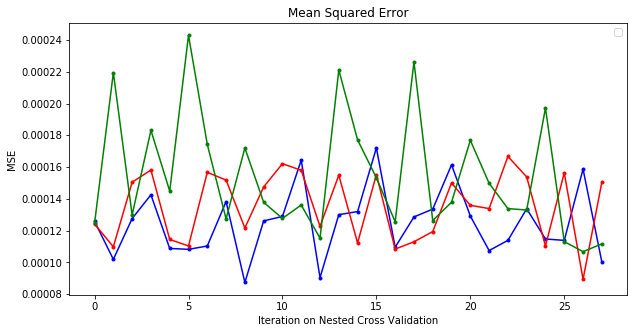

In [36]:
df_mse = result.copy()
df_mse['MSE_siedco'] = df_mse.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_siedco']), axis=1)
df_mse['MSE_rnmc'] = df_mse.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_rnmc']), axis=1)
df_mse['MSE_nuse'] = df_mse.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_nuse']), axis=1)

fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.plot(df_mse.index.values, df_mse['MSE_siedco'].values, marker=".",color='blue')
rnmc = ax.plot(df_mse.index.values, df_mse['MSE_rnmc'].values, marker=".",color='red')
nuse = ax.plot(df_mse.index.values, df_mse['MSE_nuse'].values, marker=".",color='green')
#multimodal_average = ax.scatter(result.index.values,result['multimodal_average_entropy'].values, marker=".",color='orange')
#multimodal_max = ax.scatter(result.index.values,result['multimodal_max_entropy'].values, marker=".",color='blue')
#multimodal_max_cell = ax.scatter(result.index.values,result['multimodal_max_cell_entropy'].values, marker=".",color='black')
ax.set_title('Mean Squared Error')
#ax.set_ylim(0,0.00020)
ax.legend((siedco, rnmc, nuse),('siedco', 'rnmc', 'nuse'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel('MSE')
plt.show()